In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#clase para los individuos del problema de QAP

class QAP:
    def __init__(self, distancias, flujos):
        self.distancias = distancias
        self.flujos = flujos

    def evaluate(self, permutacion):
        n = len(permutacion)
        suma = 0
        for i in range(n):
            for j in range(i + 1, n):
                suma += self.flujos[i, j] * self.distancias[permutacion[i] - 1,permutacion[j] - 1]
        return suma

In [11]:

#funcion de lectura de archivos
def leerArchivo(nombre):
    with open(nombre, 'r') as archivo:
        lines = archivo.readlines()

    # Leer el número de variables
    nInstalaciones = int(lines[0].strip())

    # Leer la matriz de flujos
    matrizF = []
    for i in range(nInstalaciones):
        matrizF.append(list(map(int, lines[2 + i].strip().split())))

    # Leer la matriz de distancias
    matrizD = []
    for i in range(nInstalaciones):
        matrizD.append(list(map(int, lines[3 + nInstalaciones + i].strip().split())))
    archivo.close()
    return nInstalaciones, matrizF, matrizD




In [112]:
def GA(QAP, population_size, mutation_rate, generations, crosstype="onepoint", elite_ratio=0.1):
    def generarPoblacionInicial(size):
        return [np.random.permutation(len(QAP.distancias)) for _ in range(size)]

    def evaluar(poblacion):
        return [QAP.evaluate(individual) for individual in poblacion]

    def SeleccionarPadres(poblacion, fitness):
        if not all(np.isfinite(f) for f in fitness):
            raise ValueError("Hay valores no finitos en fitness: {}".format(fitness))
        
        fitness_probs = [1 / f if f > 0 else 1e-10 for f in fitness]
                
        if not all(np.isfinite(p) for p in fitness_probs):
            raise ValueError("Hay valores no finitos en fitness_probs: {}".format(fitness_probs))

        sum_probs = sum(fitness_probs)
        if sum_probs == 0:
            raise ValueError("Suma de fitness_probs debe ser mayor que cero")
        
        fitness_probs = [p / sum_probs for p in fitness_probs]
        
        if not all(np.isfinite(p) for p in fitness_probs):
            raise ValueError("Hay valores no finitos en fitness_probs después de la normalización: {}".format(fitness_probs))
        
        selected = random.choices(poblacion, weights=fitness_probs, k=len(poblacion))
        return selected

    def heuristic_crossover(parent1, parent2, fitness1, fitness2):
        # Asegurarse de que el padre con mejor fitness sea siempre el primero
        if fitness1 < fitness2:
            parent1, parent2 = parent2, parent1
        
        size = len(parent1)
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        
        # Generar child1 como una combinación heurística de parent1 y parent2
        for i in range(size):
            if parent1[i] not in child1:
                child1[i] = parent1[i]
            else:
                for gene in parent2:
                    if gene not in child1:
                        child1[i] = gene
                        break
        
        # Generar child2 de la misma forma
        for i in range(size):
            if parent2[i] not in child2:
                child2[i] = parent2[i]
            else:
                for gene in parent1:
                    if gene not in child2:
                        child2[i] = gene
                        break

        return child1, child2

    def two_point_crossover(parent1, parent2):
      size = len(parent1)
      cut1, cut2 = sorted(np.random.randint(0, size, 2))
      child1 = np.zeros_like(parent1)
      child2 = np.zeros_like(parent2)
      
      child1[cut1:cut2] = parent1[cut1:cut2]
      child2[cut1:cut2] = parent2[cut1:cut2]
      
      used = set(child1[cut1:cut2])
      j = cut2
      for i in range(size):
          if parent2[i] not in used:
              if j == size:
                  j = 0
              child1[j] = parent2[i]
              j += 1
      
      used = set(child2[cut1:cut2])
      j = cut2
      for i in range(size):
          if parent1[i] not in used:
              if j == size:
                  j = 0
              child2[j] = parent1[i]
              j += 1
    
      return child1, child2
      
    def uniform_crossover(parent1, parent2):
        size = len(parent1)
        child1 = [-1] * size
        child2 = [-1] * size

        used1 = set()
        used2 = set()

        for i in range(size):
            if random.random() < 0.5:
                child1[i] = parent1[i]
                used1.add(parent1[i])
            else:
                child1[i] = parent2[i]
                used1.add(parent2[i])
                
            if random.random() < 0.5:
                child2[i] = parent1[i]
                used2.add(parent1[i])
            else:
                child2[i] = parent2[i]
                used2.add(parent2[i])

        # Fill missing genes
        missing1 = [gene for gene in parent1 if gene not in used1]
        missing2 = [gene for gene in parent2 if gene not in used2]

        for i in range(size):
            if child1[i] == -1:
                child1[i] = missing1.pop(0)
            if child2[i] == -1:
                child2[i] = missing2.pop(0)

        return np.array(child1), np.array(child2)

    def one_point_crossover(parent1, parent2):
        cut = np.random.randint(1, len(parent1) - 1)
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        
        child1[:cut] = parent1[:cut]
        child2[:cut] = parent2[:cut]
        
        used1 = set(child1[:cut])
        used2 = set(child2[:cut])
        
        j = cut
        for gene in parent2:
            if gene not in used1:
                child1[j] = gene
                j += 1
                if j == len(parent1):
                    break
        
        j = cut
        for gene in parent1:
            if gene not in used2:
                child2[j] = gene
                j += 1
                if j == len(parent2):
                    break
        
        return child1, child2

    def mutate(individual):
        i, j = np.random.randint(0, len(individual), size=2)
        individual[i], individual[j] = individual[j], individual[i]

    population = generarPoblacionInicial(population_size)
    fitness = evaluar(population)
    best_fitness = []
    best_fitness.append(min(fitness))
    elite_size = int(population_size * elite_ratio)

    for _ in range(generations):
        selected_parents = SeleccionarPadres(population, fitness)
        #print('selected_parents', selected_parents)
        next_population = []
        
        # Preservar los mejores individuos (elitismo)
        elite_indices = np.argsort(fitness)[:elite_size]
        elites = [population[i] for i in elite_indices]
        next_population.extend(elites)
        
        for i in range(elite_size, population_size, 2):
            if i + 1 >= population_size:
              break
            if (crosstype == "onepoint"):
              child1, child2 = one_point_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "twopoint"):    
              child1, child2 = two_point_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "uniform"):
              child1, child2 = uniform_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "heuristic"):
              child1, child2 = heuristic_crossover(selected_parents[i], selected_parents[i+1], fitness[i], fitness[i+1])

            # print(child1, child2)
        
            if random.random() < mutation_rate:
                mutate(child1)
            if random.random() < mutation_rate:
                mutate(child2)

            next_population.extend([child1, child2])

        fitness = evaluar(next_population)
        population = next_population
        best_fitness.append(min(fitness))
    best_individual = population[np.argmin(fitness)]
    #best_fitness = min(fitness)
    return best_individual, best_fitness

In [58]:
nArchivo = input('Ingrese nombre del archivo de QAP: ')

# Lectura matrices
nInstalaciones,matrizF,matrizD, = leerArchivo(nArchivo)


print(f"Cantidad de Instalaciones: {nInstalaciones}")
print("Matriz de flujos:")
for row in matrizF:
    print(row)
print("Matriz de distancias:")
for row in matrizD:
    print(row)


matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)

Cantidad de Instalaciones: 26
Matriz de flujos:
[53, 67, 66, 66, 66, 53, 53, 53, 53, 53, 73, 53, 53, 53, 66, 53, 53, 53, 53, 85, 73, 73, 73, 73, 53, 53]
[66, 53, 66, 66, 66, 53, 53, 53, 53, 53, 53, 73, 53, 53, 66, 53, 53, 53, 53, 73, 85, 73, 73, 73, 53, 53]
[66, 66, 53, 66, 66, 53, 53, 53, 53, 53, 53, 53, 73, 53, 66, 53, 53, 53, 53, 73, 73, 85, 73, 73, 53, 53]
[66, 66, 66, 53, 66, 53, 53, 53, 53, 53, 53, 53, 53, 73, 73, 53, 53, 53, 53, 73, 73, 73, 85, 85, 53, 53]
[66, 66, 66, 66, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 73, 53, 53, 53, 53, 73, 73, 73, 85, 85, 53, 53]
[53, 53, 53, 53, 53, 53, 66, 66, 66, 66, 53, 53, 53, 53, 53, 73, 73, 53, 53, 53, 53, 53, 53, 53, 85, 85]
[53, 53, 53, 53, 53, 66, 53, 66, 66, 66, 53, 53, 53, 53, 53, 73, 73, 53, 53, 53, 53, 53, 53, 53, 85, 85]
[53, 53, 53, 53, 53, 66, 66, 53, 66, 66, 53, 53, 53, 53, 53, 66, 53, 73, 53, 53, 53, 53, 53, 53, 73, 73]
[53, 53, 53, 53, 53, 66, 66, 66, 53, 66, 53, 53, 53, 53, 53, 66, 53, 53, 73, 53, 53, 53, 53, 53, 73, 73]
[53, 53

In [95]:
def graficar(valoresObjetivo):
    '''    
    Función que grafica la convergencia del valor objetivo
    '''
    grafico = plt.plot(valoresObjetivo)
    plt.title('Evolución del Mejor Fitness')
    plt.ylabel(u"Valor objetivo")
    plt.xlabel(u"Generaciones")
    plt.show()
    return True

Mejor solución: [17 22 22 10 17 10 10 17 17 17 22 24 10 10 17 10 10 10 10 22 17 17 17 17
 17 17]
Costo de la mejor solución: [2478432, 1257552, 708532, 708532, 476842, 466972, 392855, 262010, 262010, 82409, 82409, 82409, 34072, 34072, 19841, 19841, 19841, 19841, 14917, 14917, 13167, 12841, 12841, 12841, 12841, 12841, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12430, 12

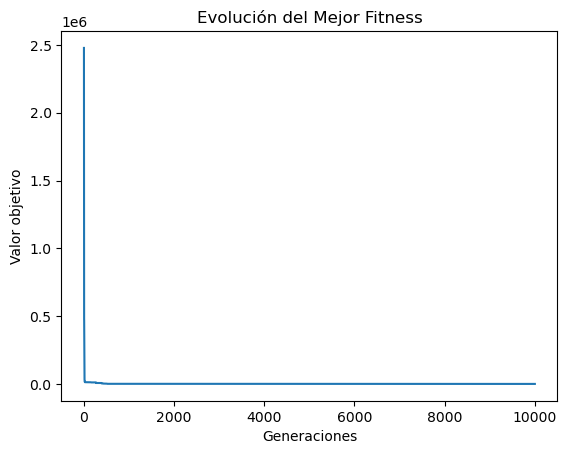

True

In [113]:
instanciaQAP = QAP(matrizD2, matrizF2)
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "uniform", elite_ratio=0.1)
print("Mejor solución:", mejorSoluciones)
print("Costo de la mejor solución:", mejoresCostos)
graficar(mejoresCostos)

Mejor solución: [20  6 14 15  8 11  3 19 24 21  1  9 18  5 22  2 13 12  7 17 10 23 16 25
  4  0]
Costo de la mejor solución: [2548903, 2548903, 2541943, 2541943, 2482350, 2482350, 2482350, 2382329, 2382329, 2382329, 2382329, 2382329, 2382329, 2382329, 2359548, 2359548, 2339079, 2334494, 2329131, 2329131, 2329131, 2321906, 2306720, 2287266, 2283506, 2271601, 2271601, 2268442, 2268442, 2264546, 2264546, 2264546, 2262934, 2262934, 2262934, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2247907, 2

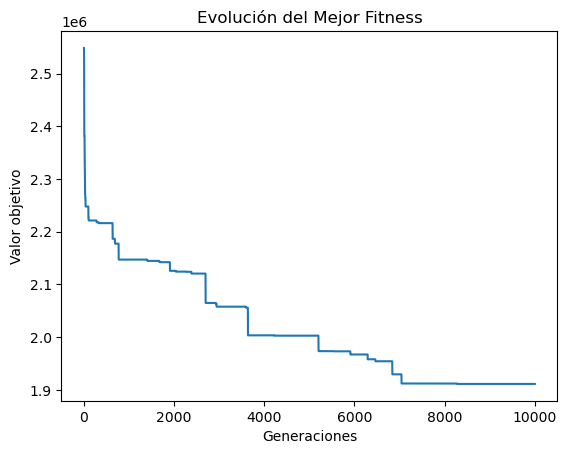

True

In [114]:
instanciaQAP = QAP(matrizD2, matrizF2)
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, elite_ratio=0.1)
print("Mejor solución:", mejorSoluciones)
print("Costo de la mejor solución:", mejoresCostos)
graficar(mejoresCostos)

Mejor solución: [20 19 12 14 18  5  7  6 13 21 15  1 11  8 10  0  3  9  2 22 17 23 24 25
 16  4]
Costo de la mejor solución: [2589531, 2519596, 2397557, 2397557, 2357157, 2357157, 2357157, 2338038, 2338038, 2338038, 2338038, 2338038, 2338038, 2338038, 2338038, 2338038, 2338038, 2338038, 2338038, 2290042, 2275084, 2275084, 2275084, 2246987, 2246987, 2233538, 2223642, 2223642, 2223642, 2213209, 2213209, 2212179, 2212179, 2212179, 2202985, 2202985, 2154063, 2154063, 2154063, 2151006, 2151006, 2151006, 2151006, 2151006, 2151006, 2151006, 2151006, 2151006, 2151006, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2129136, 2103374, 2103374, 2103374, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101890, 2101125, 2101125, 2101125, 2091546, 2091546, 2091546, 2091546, 2090989, 2090989, 2090989, 2090989, 2

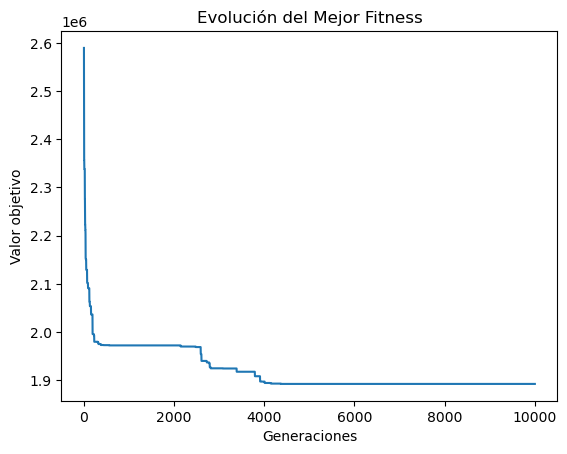

True

In [115]:
instanciaQAP = QAP(matrizD2, matrizF2)
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "twopoint", elite_ratio=0.1)
print("Mejor solución:", mejorSoluciones)
print("Costo de la mejor solución:", mejoresCostos)
graficar(mejoresCostos)

Mejor solución: [20  6 24 19 13 14 21 12 25 18 15  1  5  7 11 10  8  3  9 17 23 22  4  0
 16  2]
Costo de la mejor solución: [2453551, 2453551, 2453551, 2427119, 2405808, 2345151, 2345151, 2345151, 2323427, 2282846, 2268593, 2268593, 2268593, 2268593, 2268593, 2268593, 2268593, 2192813, 2192813, 2187722, 2187722, 2187722, 2187722, 2187722, 2187722, 2167778, 2167778, 2167778, 2167778, 2167778, 2167778, 2167778, 2167778, 2165861, 2165861, 2165861, 2165861, 2165861, 2165597, 2165597, 2165597, 2165597, 2164226, 2164226, 2147197, 2147197, 2147197, 2147197, 2145298, 2145298, 2145298, 2145298, 2145298, 2145298, 2145298, 2145298, 2145298, 2145298, 2145298, 2145298, 2143198, 2143198, 2143198, 2142732, 2142732, 2142732, 2142732, 2142732, 2142732, 2142732, 2142732, 2142732, 2142732, 2142732, 2142732, 2133661, 2097338, 2097338, 2097338, 2097338, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2096678, 2090853, 2

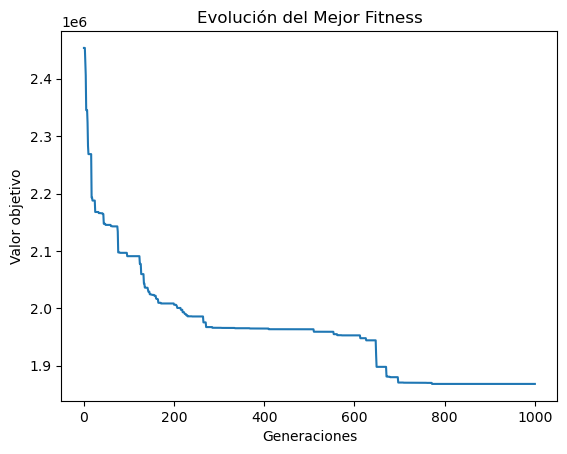

True

In [116]:
instanciaQAP = QAP(matrizD2, matrizF2)
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 200, 0.01, 1000)
print("Mejor solución:", mejorSoluciones)
print("Costo de la mejor solución:", mejoresCostos, "heuristic")
graficar(mejoresCostos)